In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [28]:
df = pd.read_csv(r'C:\Users\Germán\Github\ProyectoFinal\data\vehiculos-de-segunda-mano-sample.csv')

## Duplicados

In [29]:
#ver cantidad de duplicados 
df.duplicated().sum()


np.int64(237)

In [30]:
# Eliminamos duplicados 
df = df.drop_duplicates()

In [31]:
print(df.shape)

(99763, 28)


In [32]:
#Mostrar nombres de cada columna en una lista
print(df.columns)


Index(['vehicle_type', 'make', 'model', 'version', 'fuel', 'year', 'kms',
       'power', 'doors', 'shift', 'color', 'photos', 'description', 'price',
       'currency', 'location', 'publish_date', 'update_date', 'dealer_name',
       'dealer_description', 'dealer_address', 'dealer_zip_code',
       'dealer_city', 'dealer_country_code', 'dealer_is_professional',
       'dealer_website', 'dealer_registered_at', 'date'],
      dtype='object')


Drop columns

In [33]:
# 'dealer_city', 'dealer_country_code'

In [34]:
#Drop 'vehicle_type','doors','color','photos', 'description','currency','update_date','dealer_description','dealer_address', 'dealer_zip_code','dealer_is_professional','dealer_city', 'dealer_country_code','dealer_website','dealer_registered_at', 'date'
df = df.drop(['dealer_name','vehicle_type','doors','color','photos', 'description','currency','update_date','dealer_description','dealer_is_professional','dealer_website','dealer_registered_at',"date"], axis=1)

In [35]:
df.duplicated().sum()


np.int64(57058)

In [36]:
df.drop_duplicates(inplace=True)

In [37]:
df.shape

(42705, 15)

## Nulls

In [48]:
#Mostramos los nulos en porcetaje con relacion al total por cada fila 
df.isnull().sum()/df.shape[0]*100

make                   0.0
model                  0.0
version                0.0
fuel                   0.0
year                   0.0
kms                    0.0
power                  0.0
shift                  0.0
price                  0.0
location               0.0
publish_date           0.0
dealer_address         0.0
dealer_zip_code        0.0
dealer_city            0.0
dealer_country_code    0.0
dtype: float64

### Drop nulls from version and kms

In [39]:
#Drop nuls de "verion", kms, power,dealer_name
df = df.dropna(subset=['version', 'kms',"dealer_address"])

### Fixing Fuel, Power and Shift nulls

In [40]:
#Lista de variables a rellenar
variables = ['fuel', 'power', 'shift']
 
# Función para calcular la moda o mediana por modelo
def calculate_stat_by_model(df, var):
    if var == 'power':
        return df.groupby('model')[var].transform(lambda x: x.median() if not pd.isna(x.median()) else None)
    else:
        return df.groupby('model')[var].transform(lambda x: x.mode()[0] if not x.mode().empty else None)
 
# Función para rellenar los valores nulos
def fill_missing_values(df, var):
    stat_by_model = calculate_stat_by_model(df, var)
    df[var] = df[var].fillna(stat_by_model)
    return df
 
# Aplicar la función para cada variable
for var in variables:
    df = fill_missing_values(df, var)

c:\Users\Germán\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [41]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
 
# Mostrar el resultado completo para 'shift'
shift_nulls = df[df['shift'].isnull()][['make', 'model']].value_counts()
print("Shift Nulls:")
print(shift_nulls)

# Mostrar el resultado completo para 'power'
power_nulls = df[df['power'].isnull()][['make', 'model']].value_counts()
print("\nPower Nulls:")
print(power_nulls)

# Mostrar el resultado completo para 'fuel'
fuel_nulls = df[df['fuel'].isnull()][['make', 'model']].value_counts()
print("\nFuel Nulls:")
print(fuel_nulls)

Shift Nulls:
make   model 
Lotus  Esprit    1
Name: count, dtype: int64

Power Nulls:
make     model  
Citroen  ë-Jumpy    1
Name: count, dtype: int64

Fuel Nulls:
make     model    
Ferrari  LaFerrari    1
Lotus    Esprit       1
Tata     Indigo       1
Name: count, dtype: int64


In [42]:
#Rellenamos citroen e-jumpy con 100
df.loc[(df['make'] == 'Citroen') & (df['model'] == 'ë-Jumpy'), 'power'] = 100

In [43]:
#Rellenamos Lotus Esprit con manual
df.loc[(df['make'] == 'Lotus') & (df['model'] == 'Esprit'), 'shift'] = "manual"

In [44]:
modelos = "LaFerrari","Indigo","Esprit"
df.loc[df['model'].isin(modelos), 'fuel'] = 'Gasolina'

# Dtypes

In [45]:
df.dtypes

make                    object
model                   object
version                 object
fuel                    object
year                     int64
kms                    float64
power                  float64
shift                   object
price                    int64
location                object
publish_date            object
dealer_address          object
dealer_zip_code        float64
dealer_city             object
dealer_country_code     object
dtype: object

In [46]:
#Publish date to datetime
df['publish_date'] = pd.to_datetime(df['publish_date'])

In [47]:
df.shape

(42355, 15)

# Getting coordinates

In [70]:
df_coordenadas = df[['dealer_address', 'dealer_city', 'dealer_country_code']]

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time

def clean_address(address):
    """
    Limpia y formatea la dirección
    """
    if pd.isna(address):
        return ""
    # Convertir a string si no lo es
    address = str(address)
    # Eliminar caracteres especiales y espacios extras
    address = address.replace("NaN", "").strip()
    return address

def get_coordinates(address, city, country_code):
    """
    Get latitude and longitude from address using Nominatim geocoder
    """
    # Limpiar los componentes de la dirección
    address = clean_address(address)
    city = clean_address(city)
    country_code = clean_address(country_code)
    
    # Si no hay suficiente información, retornar None
    if not (address and city and country_code):
        print(f"Información incompleta: {address}, {city}, {country_code}")
        return None, None
    
    # Crear la dirección completa
    full_address = f"{address}, {city}, {country_code}"
    print(f"Buscando dirección: {full_address}")  # Para depuración
    
    # Initialize the geocoder
    geolocator = Nominatim(user_agent="my_vehicles_app")
    
    try:
        time.sleep(1)  # Respetar límites de la API
        
        # Intentar primero con la dirección completa
        location = geolocator.geocode(full_address)
        
        # Si falla, intentar solo con ciudad y país
        if not location:
            print("Intentando con ciudad y país...")
            location = geolocator.geocode(f"{city}, {country_code}")
        
        if location:
            print(f"Encontrado: {location.latitude}, {location.longitude}")
            return location.latitude, location.longitude
        else:
            print("No se encontró la ubicación")
            return None, None
            
    except (GeocoderTimedOut, GeocoderServiceError) as e:
        print(f"Error de geocodificación: {str(e)}")
        return None, None

def get_province_from_coordinates(lat, long):
    """
    Obtiene la provincia utilizando las coordenadas de latitud y longitud
    """
    if lat is None or long is None:
        return 'Unknown'
    
    geolocator = Nominatim(user_agent="my_vehicles_app")
    try:
        time.sleep(1)  # Respetar límites de la API
        location = geolocator.reverse((lat, long), timeout=10).raw['address']
        print(f"Provincia encontrada: {location.get('state', 'Unknown')}")  # 'state' puede variar dependiendo del país
        return location.get('state', 'Unknown')  # 'state' puede variar dependiendo del país
    except (GeocoderTimedOut, GeocoderServiceError, KeyError) as e:
        print(f"Error al obtener la provincia: {str(e)}")
        return 'Unknown'

def add_coordinates_and_state_to_df(df):
    """
    Add latitude, longitude, and state columns to the DataFrame
    """
    # Initialize new columns
    df['lat'] = None
    df['long'] = None
    df['state'] = None
    
    # Iterate through rows
    for idx, row in df.iterrows():
        print(f"\nProcesando fila {idx + 1}/{len(df)}")
        
        # Imprimir los valores para depuración
        print(f"Dirección: {row.get('dealer_address', 'No disponible')}")
        print(f"Ciudad: {row.get('dealer_city', 'No disponible')}")
        print(f"País: {row.get('dealer_country_code', 'No disponible')}")
        
        # Obtener latitud y longitud
        lat, long = get_coordinates(
            row.get('dealer_address', ''),
            row.get('dealer_city', ''),
            row.get('dealer_country_code', '')
        )
        
        # Obtener la provincia si se encontraron coordenadas
        state = get_province_from_coordinates(lat, long)
        
        # Actualizar el DataFrame
        df.at[idx, 'lat'] = lat
        df.at[idx, 'long'] = long
        df.at[idx, 'state'] = state
    
    return df


In [ ]:
# df_final = add_coordinates_and_state_to_df(df2)

Exportamos asi no tenemos que correr el codigo de arriba ya que tardo más de 15 horas en calcular las coordenadas


In [2]:
# df_final.to_csv(r'C:\Users\Germán\Github\ProyectoFinal\data\dffinal', index=False)

In [51]:
df_final = pd.read_csv(r'C:\Users\Germán\Github\ProyectoFinal\data\car_price 2.csv')

In [52]:
df_final.columns

Index(['make', 'model', 'version', 'fuel', 'year', 'kms', 'power', 'shift',
       'price', 'location', 'publish_date', 'dealer_address',
       'dealer_zip_code', 'dealer_city', 'dealer_country_code', 'lat', 'long',
       'state'],
      dtype='object')

In [53]:
df_final.shape

(42349, 18)

In [54]:
df_final.isnull().sum()

make                    0
model                   0
version                 0
fuel                    0
year                    0
kms                     0
power                   0
shift                   0
price                   0
location                0
publish_date            0
dealer_address          0
dealer_zip_code         0
dealer_city             0
dealer_country_code     0
lat                    16
long                   16
state                   0
dtype: int64

In [55]:
df_final.dropna(subset=['lat', 'long'], inplace=True)

# Más preprocesamiento

## Power

Tiene como valor mínimo 0, por lo cuál necesita algun cambio

In [11]:
potencias_sin_sentido = df_final[df_final['power']<=50][['make','model','year','price','power']].sort_values(by='price',ascending=False)

print('Cantidad de autos con potencias sin sentido:',len(potencias_sin_sentido))    

print(potencias_sin_sentido[['make','model','power','price','year']].value_counts())

Cantidad de autos con potencias sin sentido: 8
make        model   power  price  year
Citroen     AMI     8.0    6789   2023    1
                           7289   2023    1
                           7589   2023    1
Dacia       Spring  45.0   21290  2022    1
Renault     Twizy   5.0    7500   2017    1
                    11.0   6990   2017    1
                    17.0   7377   2018    1
Volkswagen  Lupo    50.0   1800   2000    1
Name: count, dtype: int64


In [12]:
# Veamos de los modelos con potencia baja cuantos hay de cada uno en el dataset
resultados = pd.DataFrame(columns=['make', 'model', 'count'])

# Bucle
for index, row in potencias_sin_sentido.iterrows():
    make = row['make']
    model = row['model']
    count = df_final[(df_final['make'] == make) & (df_final['model'] == model)].shape[0]
    resultados = pd.concat([resultados, pd.DataFrame({'make': [make], 'model': [model], 'count': [count]})], ignore_index=True)

print(resultados)

         make   model count
0       Dacia  Spring     1
1     Citroen     AMI     3
2     Renault   Twizy     3
3     Renault   Twizy     3
4     Citroen     AMI     3
5     Renault   Twizy     3
6     Citroen     AMI     3
7  Volkswagen    Lupo     5


In [13]:
#De Alpine A110 hay 3 autos, miraremos que potencia tienen en el dataset general
alpine = df_final[(df_final['make'] == 'Alpine') & (df_final['model'] == 'A110')]
alpine[['price','power']].value_counts()    

price  power
73490  292.0    2
61900  292.0    1
64000  292.0    1
       252.0    1
68000  252.0    1
       292.0    1
77000  292.0    1
79990  292.0    1
Name: count, dtype: int64

In [14]:
#Al costar más quie los demás será la versión más potente del modelo de 292cv, entonces le pondremos ese valor
df_final.loc[(df_final['make'] == 'Alpine') & (df_final['model'] == 'A110') & (df_final['power'] <= 50), 'power'] = 292

In [15]:
#La citroen berlingo le pondremos 75 cv que es el mínimo de potencia que tiene
df_final.loc[(df_final['make'] == 'Citroen') & (df_final['model'] == 'Berlingo') & (df_final['power'] <= 50), 'power'] = 75

In [16]:
# De Tesla Model S hay varios autos, miraremos qué potencia tienen en el dataset general
tesla_model_s = df_final[(df_final['make'] == 'Tesla') & (df_final['model'] == 'Model S')]
tesla_model_s[['price', 'power','kms']].value_counts()

price   power  kms     
38490   367.0  204700.0    1
39900   421.0  190000.0    1
39990   421.0  130000.0    1
41900   421.0  192900.0    1
43990   388.0  90984.0     1
48990   740.0  133500.0    1
56880   770.0  119700.0    1
56900   770.0  119700.0    1
58990   333.0  89831.0     1
61990   473.0  45000.0     1
78500   816.0  45920.0     1
87890   796.0  29743.0     1
89890   796.0  29743.0     1
149990  999.0  3046.0      1
Name: count, dtype: int64

In [17]:
#De tesla Model S es dificil predecir cual será la potencia ya que hay muchos valores distintos, así que borraremos las filas con potencia 0
df_final = df_final.drop(df_final[(df_final['make'] == 'Tesla') & (df_final['model'] == 'Model S') & (df_final['power'] <= 50)].index)

In [18]:
# De Jeep Wrangler hay varios autos, miraremos qué potencia tienen en el dataset general
jeep_wrangler = df_final[(df_final['make'] == 'Jeep') & (df_final['model'] == 'Wrangler')]
jeep_wrangler[['price', 'power', 'kms']].value_counts()

price  power  kms     
37900  200.0  79072.0     33
66500  200.0  29620.0     19
34990  200.0  103530.0     6
23990  177.0  120000.0     1
28900  200.0  135000.0     1
28500  200.0  129000.0     1
28999  177.0  75000.0      1
26500  177.0  100000.0     1
47900  272.0  56000.0      1
49990  272.0  70000.0      1
59990  200.0  60000.0      1
57900  272.0  7500.0       1
62900  380.0  2000.0       1
              2700.0       1
64990  200.0  95000.0      1
69900  381.0  15558.0      1
Name: count, dtype: int64

In [19]:
#El jeep wrangler que tenemos con 0 caballos, por precio se acerca a la versión mínima de nuetsro dataset de 177cv, así que le pondremos ese valor  
df_final.loc[(df_final['make'] == 'Jeep') & (df_final['model'] == 'Wrangler') & (df_final['power'] <= 50), 'power'] = 177

In [20]:
#Veamos que marca, modelo y precio tiene el coche cocn el valor de potencia maximo
max_power = df_final[df_final['power'] == df_final['power'].max()][['make','model','version','price','power','kms','year']]
print(max_power)

        make    model                                      version   price  \
14155  Tesla  Model S  Plaid 1020 100kWh Tracción Intregal 5p Aut.  149990   

       power     kms  year  
14155  999.0  3046.0  2023  


In [21]:
# Es imposible que un coche tenga 36k cv de potencia, por muy audi s8 que sea, con esas características y buscando en internet, el modelo ronda los 340cv, así que le pondremos ese valor
df_final.loc[(df_final['make'] == 'Audi') & (df_final['model'] == 'S8') & (df_final['power'] == 360571.0), 'power'] = 340

## Kms
Hay valores demasiado elevados que no tienen demasiado sentido con la publicación

In [22]:
#Vemos que precio tienen los autos con kilometraje superior a 600000
df_final[df_final['kms'] > 600000][['make','model','year','price','power','kms']].sort_values(by='price',ascending=False)

,make,model,year,price,power,kms
5235,Fiat,Ducato,2013,9500,180.0,750000.0
16394,Volkswagen,Golf Plus,2006,6990,115.0,740000.0
691,Nissan,Atleon,2008,6950,150.0,649000.0
9851,Iveco,Daily,2010,6655,146.0,721000.0


In [23]:
#eliminamos las filas dce vehículos con más de 900000 km
df_final = df_final.drop(df_final[df_final['kms'] > 900000].index)

In [24]:
df_final = df_final.drop(df_final[df_final['kms'] > 900000].index)

In [25]:
#Exportamos el dataset final para usar en el modelo 
df_final.to_csv(r'C:\Users\Germán\Github\ProyectoFinal\data\model.csv', index=False)

# EDA

In [26]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
year,42333.0,2016.691139,3.973795,1967.000000,2015.0000,2018.000000,2019.0000,2023.000000
kms,42333.0,86305.125647,55407.615564,0.000000,44000.0000,80701.000000,116712.0000,750000.000000
power,42333.0,143.618973,75.893234,5.000000,102.0000,126.000000,150.0000,999.000000
price,42333.0,19322.859377,16204.181551,0.000000,12089.0000,16290.000000,22500.0000,498000.000000
dealer_zip_code,42333.0,24566.883542,14625.091849,1002.000000,8734.0000,28230.000000,36211.0000,50820.000000
lat,42333.0,39.825569,1.961569,28.047874,37.9836,40.324311,41.3784,43.568866
long,42333.0,-2.484065,3.023189,-16.622750,-3.9862,-3.000000,-0.3763,3.238264


In [27]:
#Mostrar la fila con el precio mas caro
df_final[df_final['price'] == df_final['price'].max()]

,make,model,version,fuel,year,kms,power,shift,price,location,publish_date,dealer_address,dealer_zip_code,dealer_city,dealer_country_code,lat,long,state
18812,Lamborghini,Huracán,STO 650CV FULL CARBON,Gasolina,2022,10.0,650.0,automatic,498000,Colonia Pablo Iglesias,2022-07-05,"1, Calle de José Luis Sampedro, Las Canteras, ...",28520.0,Colonia Pablo Iglesias,ES,40.3703,-3.7361,Comunidad de Madrid


### Kms

In [ ]:
df_final['kms_category'] = pd.cut(df_final['kms'], bins=[0, 50000, 100000, 150000, float("inf")], labels=['Bajo', 'Medio', 'Alto', 'Muy Alto'])

#Mostrar la cantidad de autos por cada categoria
print(df_final['kms_category'].value_counts())

kms_category
Medio       15323
Bajo        12272
Alto        10058
Muy Alto     4640
Name: count, dtype: int64


C:\Users\Germán\AppData\Local\Temp\ipykernel_5988\599740204.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_final, x='kms_category', palette='viridis')


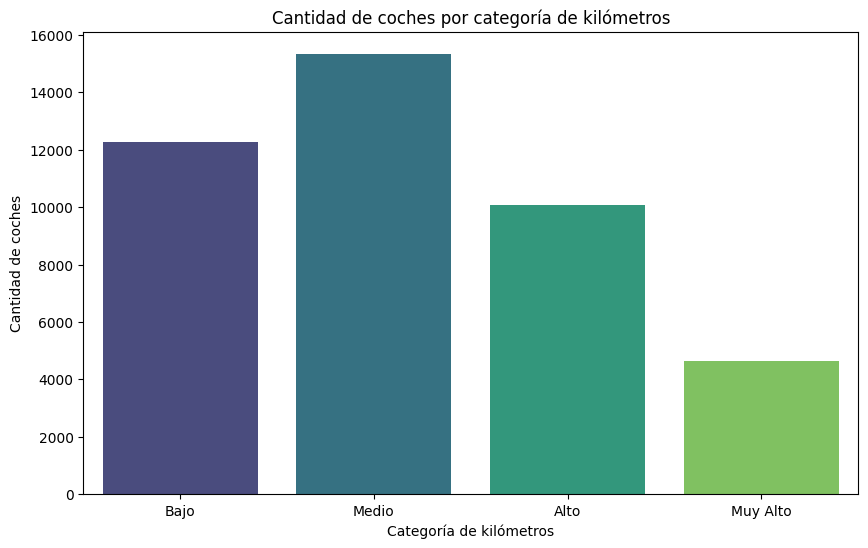

In [30]:
#Gráfico de barras de la cantidad de coches por cada categoria
plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x='kms_category', palette='viridis')
plt.title('Cantidad de coches por categoría de kilómetros')
plt.xlabel('Categoría de kilómetros')
plt.ylabel('Cantidad de coches')
plt.show()

C:\Users\Germán\AppData\Local\Temp\ipykernel_5988\1674697458.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final, x='kms_category', y='price',palette='viridis')


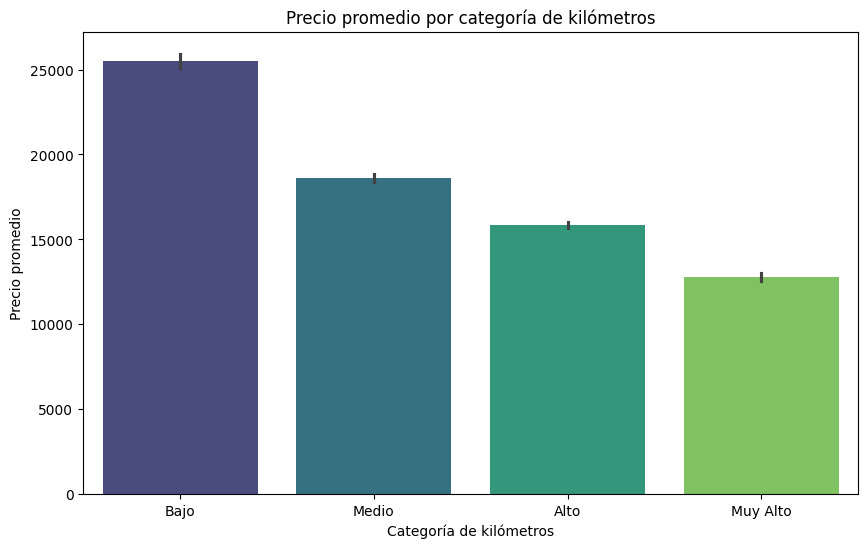

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_final, x='kms_category', y='price',palette='viridis')
plt.title('Precio promedio por categoría de kilómetros')
plt.xlabel('Categoría de kilómetros')
plt.ylabel('Precio promedio')
plt.show()

### Fuel Type y variacioón del precio segun el tipo

C:\Users\Germán\AppData\Local\Temp\ipykernel_5988\732314301.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final, x='fuel', y='price',palette='viridis')


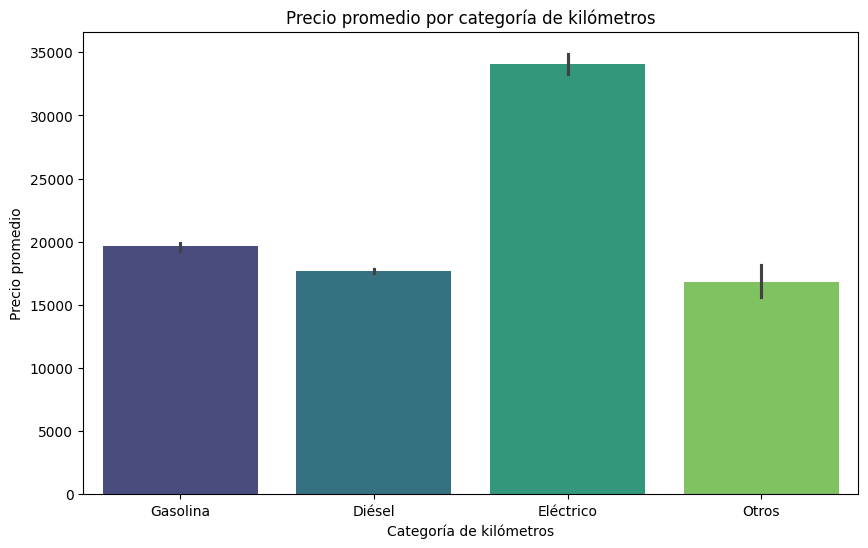

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_final, x='fuel', y='price',palette='viridis')
plt.title('Precio promedio por categoría de kilómetros')
plt.xlabel('Categoría de kilómetros')
plt.ylabel('Precio promedio')
plt.show()

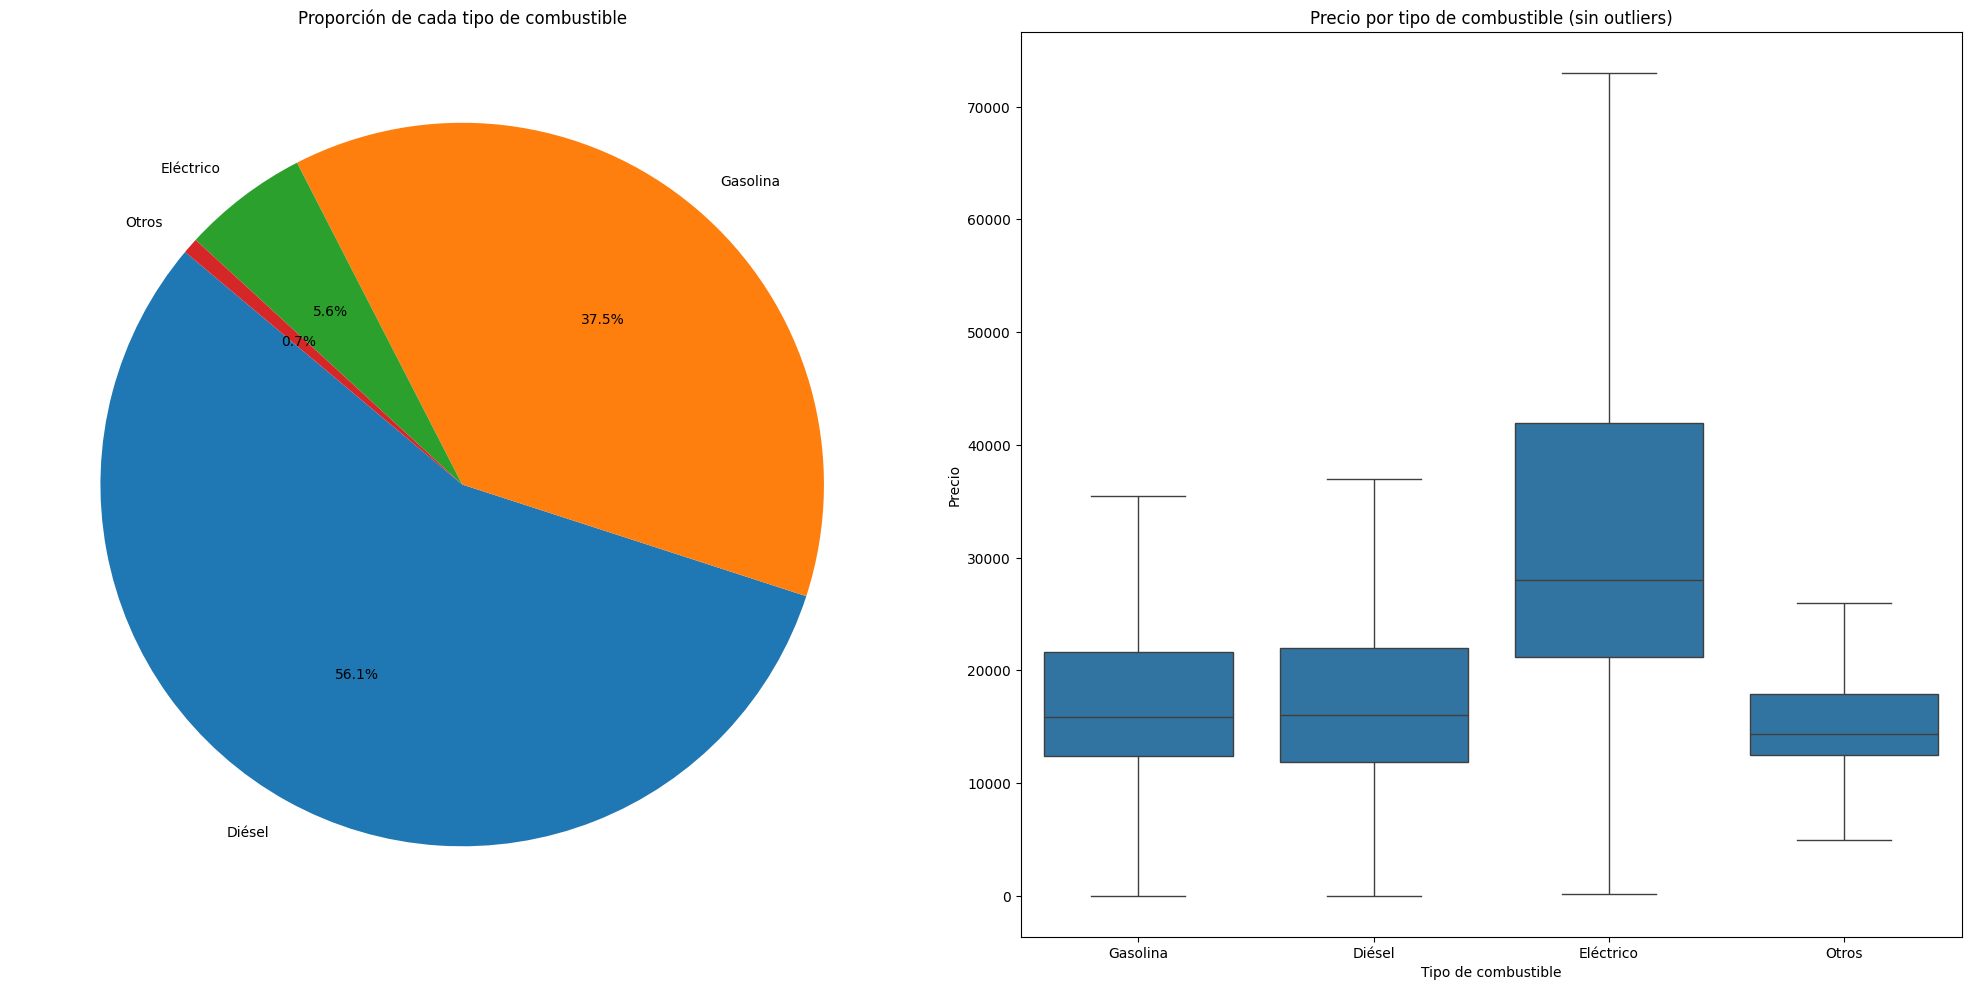

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

fuel_counts = df_final['fuel'].value_counts(normalize=True)
ax[0].pie(fuel_counts.values, labels=fuel_counts.index, autopct='%1.1f%%', startangle=140)
ax[0].set_title('Proporción de cada tipo de combustible')

sns.boxplot(x='fuel', y='price', data=df_final, ax=ax[1],showfliers=False)
ax[1].set_title('Precio por tipo de combustible (sin outliers)')
ax[1].set_xlabel('Tipo de combustible')
ax[1].set_ylabel('Precio')


plt.tight_layout()
plt.show()

### Shift Type

C:\Users\Germán\AppData\Local\Temp\ipykernel_5988\1249225033.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final, x='shift', y='price',palette='viridis')


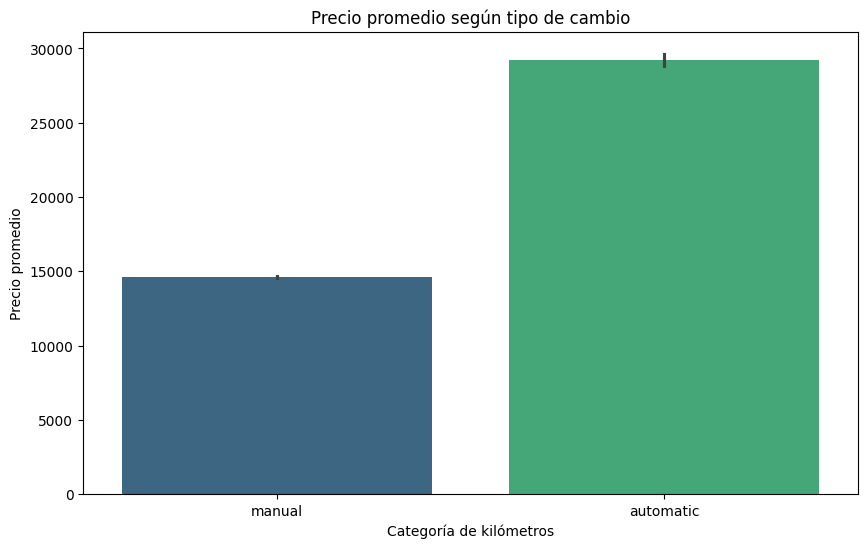

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_final, x='shift', y='price',palette='viridis')
plt.title('Precio promedio según tipo de cambio')
plt.xlabel('Categoría de kilómetros')
plt.ylabel('Precio promedio')
plt.show()

### Power

In [ ]:
df_final['power_range'] = pd.cut(df_final['power'], bins=[0, 100, 200, 300, 400, 500, float("inf")], labels=['0-100', '100-200', '200-300', '300-400', '400-500', '500+'])
print(df_final['power_range'].value_counts())

power_range
100-200    27805
0-100      10129
200-300     2447
300-400     1008
400-500      565
500+         379
Name: count, dtype: int64


C:\Users\Germán\AppData\Local\Temp\ipykernel_5988\1899876350.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_final, x='power_range', palette='viridis')


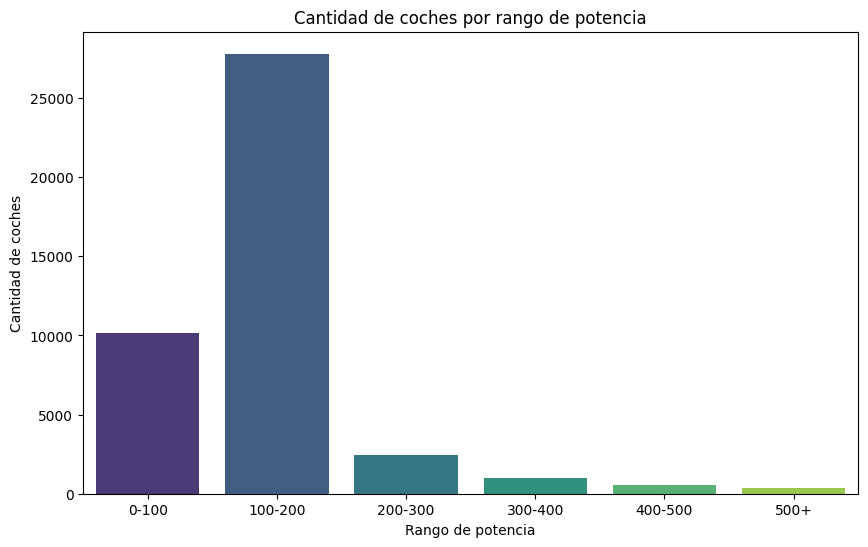

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x='power_range', palette='viridis')
plt.title('Cantidad de coches por rango de potencia')
plt.xlabel('Rango de potencia')
plt.ylabel('Cantidad de coches')
plt.show()

### Scatterplot: Relación entre año de fabricación y precio

C:\Users\Germán\AppData\Local\Temp\ipykernel_5988\3217641251.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_final, x='year', y='price', palette='viridis')


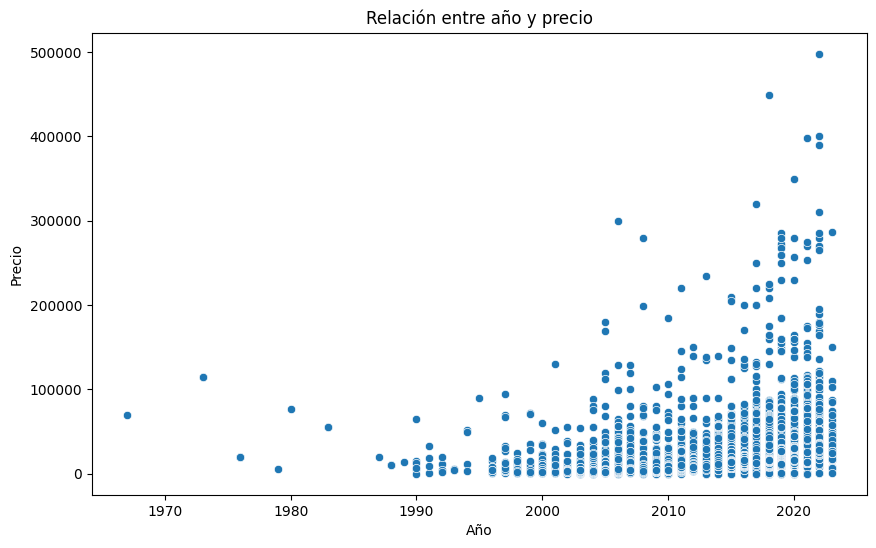

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='year', y='price', palette='viridis')
plt.title('Relación entre año y precio')
plt.xlabel('Año')
plt.ylabel('Precio')
plt.show()

### Precios medios por provincia 

C:\Users\Germán\AppData\Local\Temp\ipykernel_5988\2605619257.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final, x='state', y='price',palette='viridis')


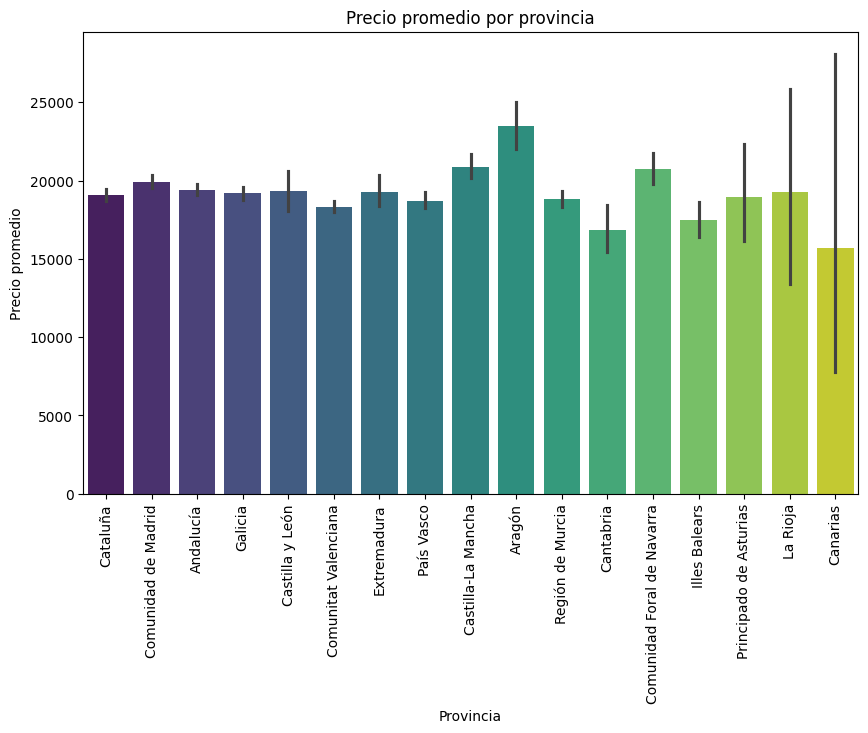

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_final, x='state', y='price',palette='viridis')
plt.title('Precio promedio por provincia')
plt.xlabel('Provincia')
plt.ylabel('Precio promedio')
plt.xticks(rotation=90)
plt.show()

## Boxplots e Histogramas

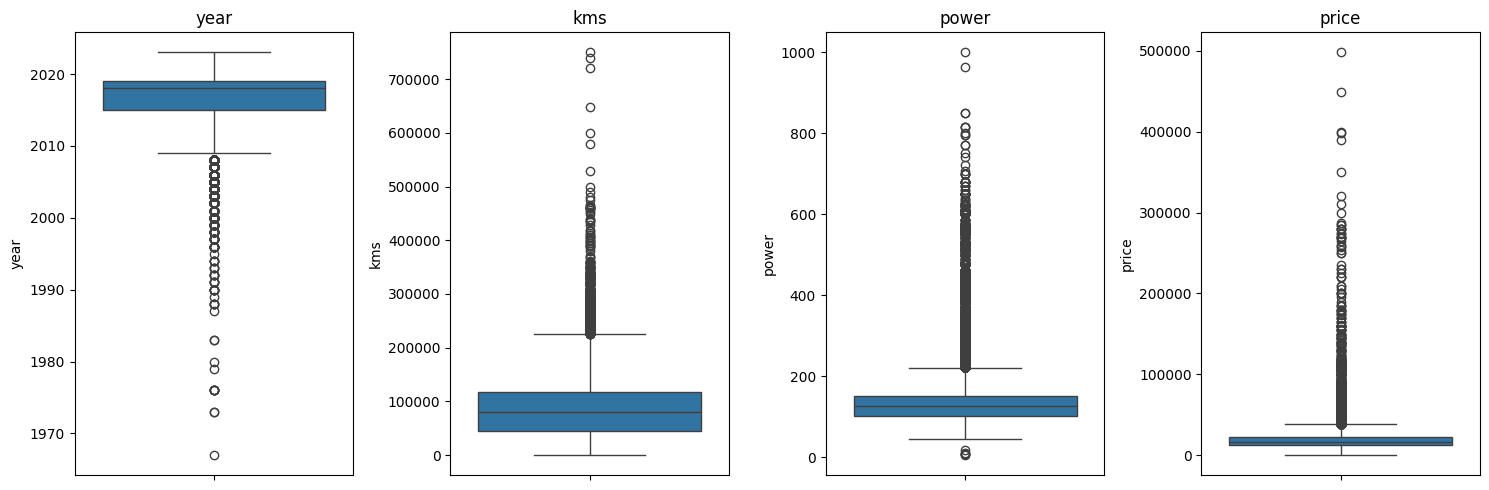

In [39]:
num_vars = df_final.select_dtypes(include=['float64', 'int64']).columns.drop(['dealer_zip_code', 'lat', 'long'])


n_cols = 4  
n_rows = (len(num_vars) + n_cols - 1) // n_cols  

plt.figure(figsize=(15, n_rows * 5))  

for i, var in enumerate(num_vars):
    plt.subplot(n_rows, n_cols, i + 1)  
    sns.boxplot(y=df_final[var])  
    plt.title(var)  
    plt.xlabel('')  

plt.tight_layout() 
plt.show()

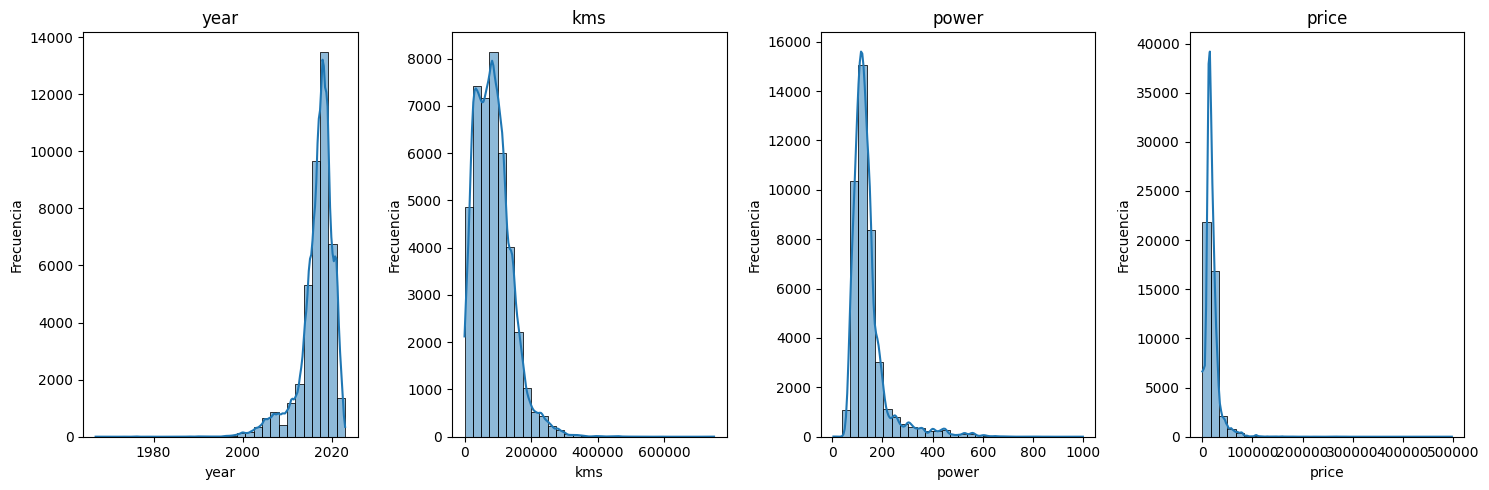

In [ ]:
num_vars = df_final.select_dtypes(include=['float64', 'int64']).columns.drop(['dealer_zip_code', 'lat', 'long'])

n_cols = 4  # Número de columnas en la cuadrícula
n_rows = (len(num_vars) + n_cols - 1) // n_cols  # Número de filas en la cuadrícula

plt.figure(figsize=(15, n_rows * 5))  # Ajustar el tamaño de la figura

# Iteración sobre las variables numéricas
for i, var in enumerate(num_vars):
    plt.subplot(n_rows, n_cols, i + 1)  # Crear un subplot
    sns.histplot(df_final[var], kde=True, bins=30)  # Crear histograma con KDE
    plt.title(var)  # Título del gráfico
    plt.xlabel(var)  # Etiqueta del eje x
    plt.ylabel('Frecuencia')  # Etiqueta del eje y

plt.tight_layout()  # Ajustar diseño
plt.show()

## Diagrama con estimacion de densidad del precio

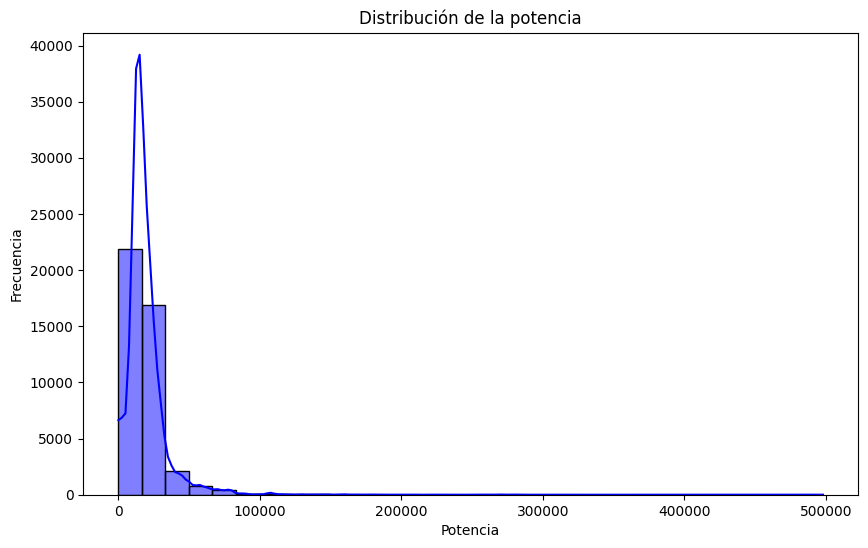

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_final['price'], kde=True, color='blue', bins=30)
plt.title('Distribución de la potencia')
plt.xlabel('Potencia')
plt.ylabel('Frecuencia')
plt.show()

## ¿Cómo afecta el kilometraje al precio? 

C:\Users\Germán\AppData\Local\Temp\ipykernel_5988\1914250760.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_price_by_kms = df_final.groupby('kms_classification')['price'].mean()


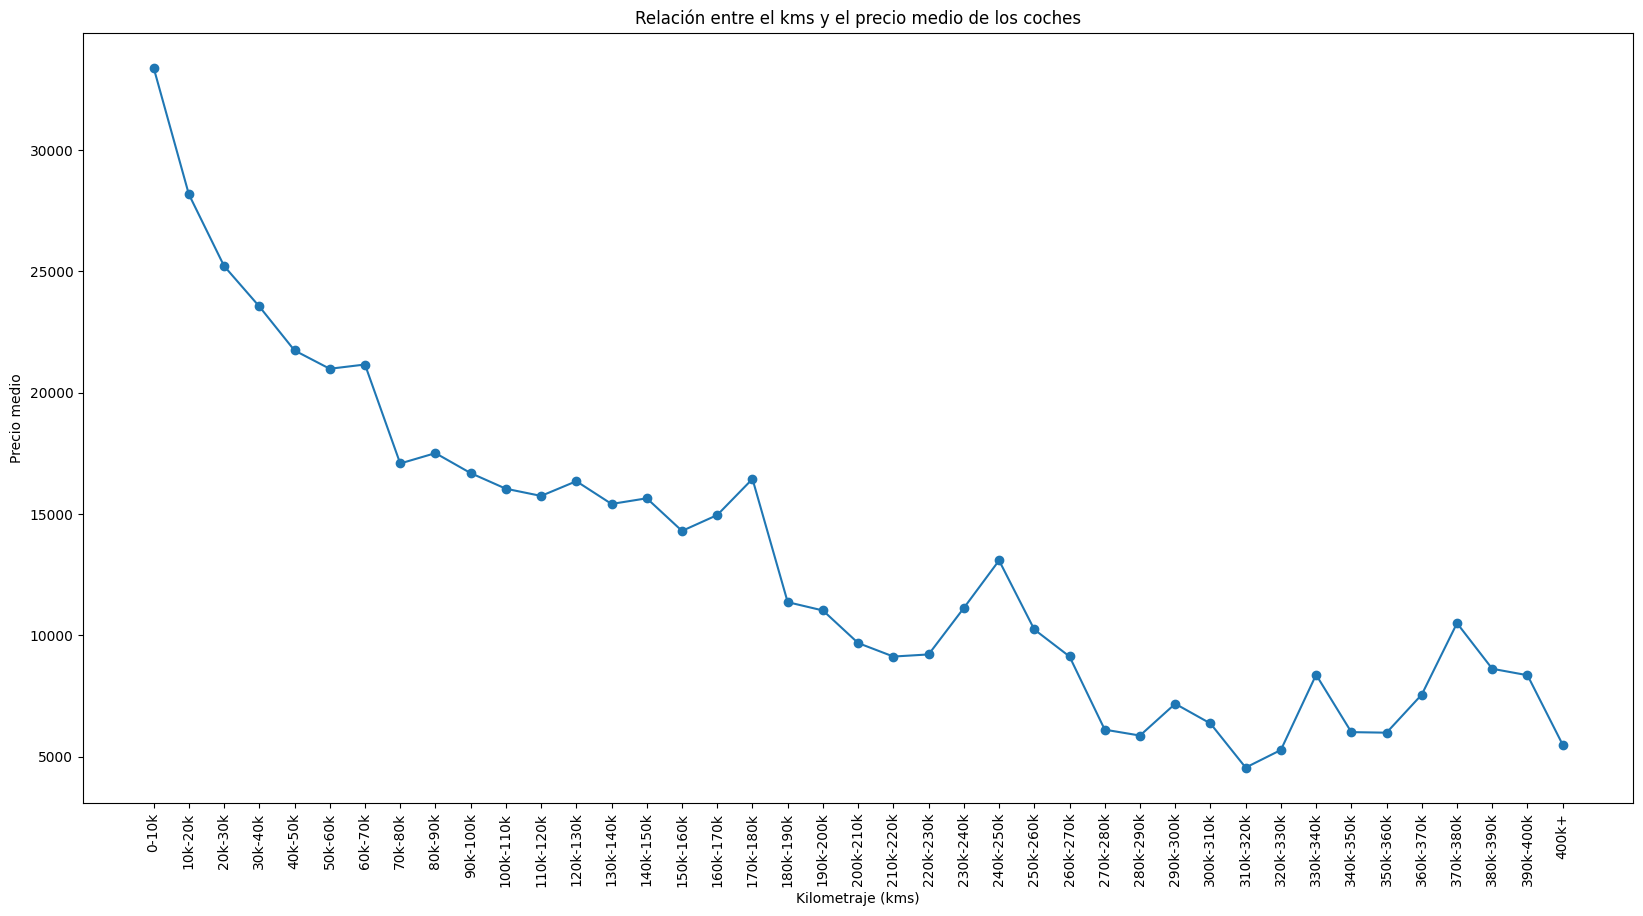

In [ ]:
df_final['kms_classification'] = pd.cut(df_final['kms'], bins=[0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000, 250000, 260000, 270000, 280000, 290000, 300000, 310000, 320000, 330000, 340000, 350000, 360000, 370000, 380000, 390000, 400000, np.inf], labels=['0-10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k', '50k-60k', '60k-70k', '70k-80k', '80k-90k', '90k-100k', '100k-110k', '110k-120k', '120k-130k', '130k-140k', '140k-150k', '150k-160k', '160k-170k', '170k-180k', '180k-190k', '190k-200k', '200k-210k', '210k-220k', '220k-230k', '230k-240k', '240k-250k', '250k-260k', '260k-270k', '270k-280k', '280k-290k', '290k-300k', '300k-310k', '310k-320k', '320k-330k', '330k-340k', '340k-350k', '350k-360k', '360k-370k', '370k-380k', '380k-390k', '390k-400k', '400k+'])

plt.figure(figsize=(20, 10))
mean_price_by_kms = df_final.groupby('kms_classification')['price'].mean()
mean_price_by_kms.plot(kind='line', marker='o')
plt.title('Relación entre el kms y el precio medio de los coches')
plt.xlabel('Kilometraje (kms)')
plt.ylabel('Precio medio')
plt.xticks(rotation=90)
plt.xticks(ticks=range(len(mean_price_by_kms.index)), labels=mean_price_by_kms.index)

plt.show()

## Diagrama de agrupación hexagonal

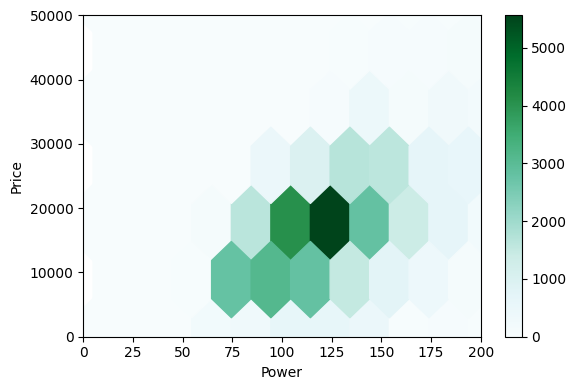

In [ ]:
ax = df_final.plot.hexbin(x='power', y='price',
                          gridsize=50, sharex=False, figsize=(6, 4))
ax.set_xlabel('Power')
ax.set_ylabel('Price')
ax.set_ylim(0, 50000)  # Establecer límite superior para el precio
ax.set_xlim(0, 200)  # Establecer límite superior para la potencia

plt.tight_layout()
plt.show()

In [57]:
df_final.head(1)

,make,model,version,fuel,year,kms,power,shift,price,location,publish_date,dealer_address,dealer_zip_code,dealer_city,dealer_country_code,lat,long,state
0,Opel,Crossland,1.2 GAS 110 GS Line 5p S/S,Gasolina,2022,5,110.0,manual,22900,Pineda de Mar,2023-02-04,"2, Carrer de Jacint Benavente, Poblenou, Pined...",8397.0,Pineda de Mar,ES,41.627681,2.689871,Cataluña


In [149]:
df_final.columns

Index(['make', 'model', 'version', 'fuel', 'year', 'kms', 'power', 'shift',
       'price', 'location', 'publish_date', 'dealer_address',
       'dealer_zip_code', 'dealer_city', 'dealer_country_code', 'lat', 'long',
       'state', 'kms_classification', 'power_classification',
       'power_classification_num', 'trend', 'power_range'],
      dtype='object')

## Mapa de coordenadas

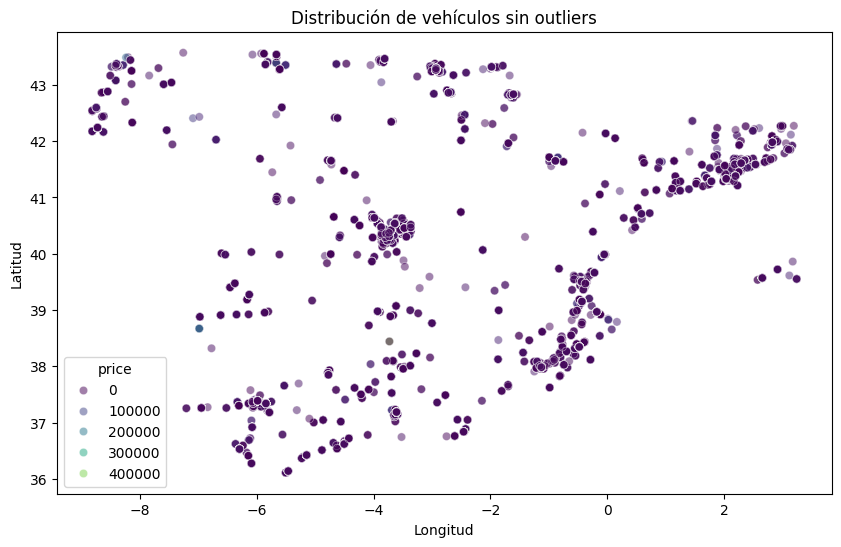

In [ ]:
Q1_lat = df_final['lat'].quantile(0.25)
Q3_lat = df_final['lat'].quantile(0.75)
IQR_lat = Q3_lat - Q1_lat

Q1_long = df_final['long'].quantile(0.25)
Q3_long = df_final['long'].quantile(0.75)
IQR_long = Q3_long - Q1_long

lower_bound_lat = Q1_lat - 1.5 * IQR_lat
upper_bound_lat = Q3_lat + 1.5 * IQR_lat

lower_bound_long = Q1_long - 1.5 * IQR_long
upper_bound_long = Q3_long + 1.5 * IQR_long

df_final_filtered = df_final[(df_final['lat'] >= lower_bound_lat) & (df_final['lat'] <= upper_bound_lat) &
                             (df_final['long'] >= lower_bound_long) & (df_final['long'] <= upper_bound_long)]

# Graficar los datos filtrados
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final_filtered, x='long', y='lat', hue='price', palette='viridis', alpha=0.5)
plt.title('Distribución de vehículos sin outliers')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()